# XFLR5 Design Work

I can use [XFLR5](http://www.xflr5.tech/xflr5.htm) to do the design work and stability analysis for a tail section. This will save me from having to write a lot of code.

## NACA 4410 Polars and Pressure Coefficients

I'll follow the [video tutorials](https://www.youtube.com/playlist?list=PLtl5ylS6jdP6uOxzSJKPnUsvMbkmalfKg) for XFLR5, starting with the Airfoil Design. The cross section of the main wing is a NACA 4410 airfoil, so I'll plot that. I'll use 250 panels because my computer is probably good enough to run with that.

Inputs:
- NACA: `4410`
- Number of Panels: `250`

The tutorial recommends that I refine the design globally to make sure there are a correct number of panels, so I did, setting the panels to 250 and leaving all other parameters the same.

Next is the Analysis part. I opened up the `Analysis/Define an Analysis` menu and set the following parameters:
- Type 1 Analysis (Since it's just an airfoil analysis)
- Reynolds Number: `308639`

I found that in order to have the coefficient of pressure plot show up after the analysis I needed to check the `Store Opp` in the Direct Foil Analysis context menu. The polar looks reasonable to me, and with a negative coefficient of pressure it'll achieve lift.

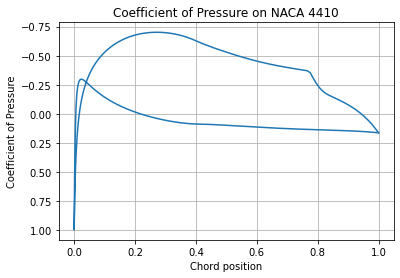

In [12]:
import numpy as np
import matplotlib.pyplot as plt

cp_data = np.genfromtxt("data/xflr5/4410/Cp_Graph.csv", skip_header=1, delimiter=",")
plt.plot(cp_data[:,0], cp_data[:,1])
plt.title("Coefficient of Pressure on NACA 4410")
plt.xlabel("Chord position")
plt.ylabel("Coefficient of Pressure")
plt.grid()
plt.gca().invert_yaxis()

Next I did the analysis across a set of angle of attacks. I chose an angle of attack increment of 0.25, and did from 0 to -10, and then 0 to 20 degrees. I got a pretty nice looking Drag Polar out of this. Initially I tried doing this with a greater range, but ran into convergence issues past -10 and 20 degrees. I also wanted to stay in the range that I used in the previous notebook's XFOIL analysis.

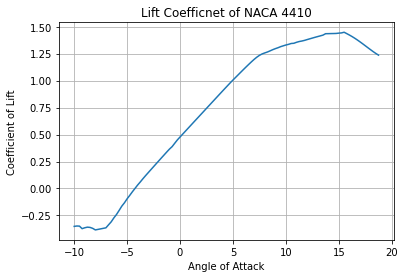

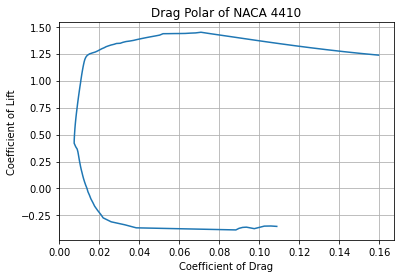

In [13]:
drag_polar_data = np.genfromtxt("data/xflr5/4410/Polar_T1_Re0.309_M0.00_N9.0.csv", delimiter=",", skip_header=10)
alpha = drag_polar_data[:,0]
cl = drag_polar_data[:,1]
cd = drag_polar_data[:,2]

plt.plot(alpha, cl)
plt.title("Lift Coefficnet of NACA 4410")
plt.xlabel("Angle of Attack")
plt.ylabel("Coefficient of Lift")
plt.grid()

plt.figure()
plt.plot(cd, cl)
plt.title("Drag Polar of NACA 4410")
plt.xlabel("Coefficient of Drag")
plt.ylabel("Coefficient of Lift")
plt.grid()

## Batch Analysis for 4410

It makes sense to do a batch analysis for various Reynolds numbers to see the performance at different speeds. I predicted that the Stratosurfer would probably cruise at about 50 mph. I coulld do some analysis up to 75 mph to see how it performs when flying faster.

To do a Batch Analysis, I'll need to select a range of Reynolds numbers. I figure attempting to fly between 10 mph to 75 mph would be good. The corrosponding Reynolds numbers can be calculated.

In [14]:
mph_to_ms = 0.447
v_inf_min_ms = 10 * mph_to_ms
v_inf_max_ms = 75 * mph_to_ms

rho_inf_si = 1.1117 # Density, kg/m^3
mu = 1.778e-5

chord_m = 0.215 / 0.98

Re_min = rho_inf_si * v_inf_min_ms * chord_m / mu
Re_max = rho_inf_si * v_inf_max_ms * chord_m / mu
print(f"Min Reynolds Number: {Re_min:.0f}")
print(f"Max Reynolds Number: {Re_max:.0f}")

Min Reynolds Number: 61316
Max Reynolds Number: 459872


Running the batch analysis, I can see that weird things start happening below a Reynolds number of 60,000.

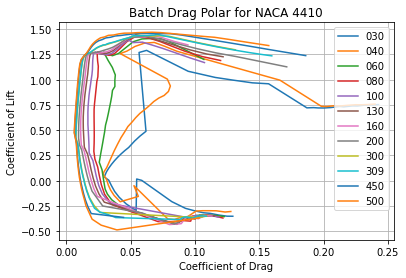

In [15]:
import numpy as np

re_nums = [30, 40, 60, 80, 100, 130, 160, 200, 300, 309, 450, 500]
polars = {}
for re in re_nums:
    re_label = f"{re:.0f}".zfill(3)
    filename = f"data/xflr5/4410/Polar_T1_Re0.{re_label}_M0.00_N9.0.csv"
    polars[re] = np.genfromtxt(filename, delimiter=",", skip_header=10)
    
    cl = polars[re][:,1]
    cd = polars[re][:,2]
    plt.plot(cd, cl, label=re_label)

plt.title("Batch Drag Polar for NACA 4410")
plt.xlabel("Coefficient of Drag")
plt.ylabel("Coefficient of Lift")
plt.grid()
plt.legend()

In [16]:
re_min_safe = 60e3

v_inf_ms = re_min_safe * mu / (rho_inf_si * chord_m)

v_inf_mph = v_inf_ms / mph_to_ms

print(f"Min speed before stalling: {v_inf_mph:.1f} mph")

Min speed before stalling: 9.8 mph


## Analysis for Varying Reynolds Number (Type 4 Analysis)

According to the lift vs alpha curve, coefficient of lift drops somewhere between Reynolds Numbers of 40,000 and 60,000. I'll take a look at what a change in Reynolds number does at a constant angle of attack of 5 degrees to try to find the Critical Reynold's Number. I should fly above this speed for good performance.

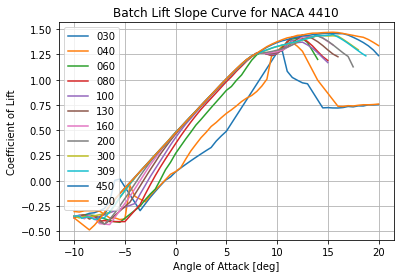

In [17]:
for re in re_nums:
    re_label = f"{re:.0f}".zfill(3)
    alpha = polars[re][:,0]
    cl = polars[re][:,1]
    plt.plot(alpha, cl, label=re_label)

plt.title("Batch Lift Slope Curve for NACA 4410")
plt.xlabel("Angle of Attack [deg]")
plt.ylabel("Coefficient of Lift")
plt.grid()
plt.legend()

I ran the Type 4 analysis (varying Reynold's Number) at an angle of attack of 5 degrees, and with the range 10,000 to 100,000 Reynolds Number. I did a second type four analysis with a trip at 40% the chord length, since that's where the tallest part of the airfoil is.

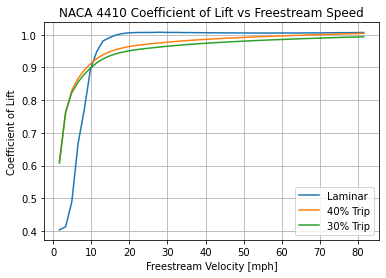

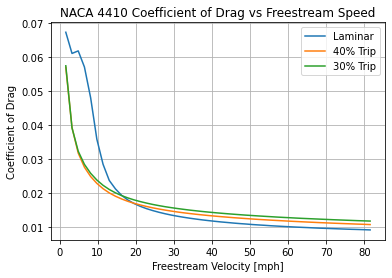

In [28]:
type_four = np.genfromtxt("data/xflr5/4410/T4_Al5.00_M0.00_N9.0_Trip1.0.csv", delimiter=",", skip_header=10)
type_four_re = type_four[:,1]
type_four_cl = type_four[:,2]
type_four_cd = type_four[:,3]

type_four_tripped = np.genfromtxt("data/xflr5/4410/T4_Al5.00_M0.00_N9.0_Trip0.4.csv", delimiter=",", skip_header=10)
tripped_40_re = type_four_tripped[:,1]
tripped_40_cl = type_four_tripped[:,2]
tripped_40_cd = type_four_tripped[:,3]

type_four_tripped = np.genfromtxt("data/xflr5/4410/T4_Al5.00_M0.00_N9.0_Trip0.3.csv", delimiter=",", skip_header=10)
tripped_30_re = type_four_tripped[:,1]
tripped_30_cl = type_four_tripped[:,2]
tripped_30_cd = type_four_tripped[:,3]

re_to_mph = mu / (rho_inf_si * chord_m) / mph_to_ms

plt.plot(type_four_re * re_to_mph, type_four_cl, label="Laminar")
plt.plot(tripped_40_re * re_to_mph, tripped_40_cl, label="40% Trip")
plt.plot(tripped_30_re * re_to_mph, tripped_30_cl, label="30% Trip")
plt.title("NACA 4410 Coefficient of Lift vs Freestream Speed")
plt.xlabel("Freestream Velocity [mph]")
plt.ylabel("Coefficient of Lift")
plt.grid()
plt.legend()

plt.figure()
plt.plot(type_four_re * re_to_mph, type_four_cd, label="Laminar")
plt.plot(tripped_40_re * re_to_mph, tripped_40_cd, label="40% Trip")
plt.plot(tripped_30_re * re_to_mph, tripped_30_cd, label="30% Trip")
plt.title("NACA 4410 Coefficient of Drag vs Freestream Speed")
plt.xlabel("Freestream Velocity [mph]")
plt.ylabel("Coefficient of Drag")
plt.grid()
plt.legend()

So the critical Reynold's Number occurs somewhere around 10 mph. I don't plan to fly this slowly normally, but it might help out a lot to reduce the drag during landing and takeoff. I may want to think about how it affects cruise since it does increase the coefficient of drag at cruise velocity.

Drag starts to increase a lot under 15 mph. Tripping the airfoil at 40% of the chord looks like it won't work to reduce the drag that much at 15 mph.

I went back and did the analysis for a trip at 30%. It has just about the same effect as a 40% trip.